### Data Engineering Capstone Project

#### Project Summary

This project focuses on providing a solution to perform analytics to identify trends and patterns on US Immigration data based on demographics, temperatures and airports. This project will help answer questions like which is the most prominent race which traveled to a specific city or state in the US during a certain time period in the year, are people traveling to colder regions or warmer regions and at what time during the year, etc.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import isnull, when, count, col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import TimestampType, StringType
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import pandas as pd

### Step 1: Scope the Project and Gather Data

#### Project Scope

In order to support analytics on the US Immigration Data this project focuses on designing and building a data model using the US demographics, airport and temperature data. In order to support such analytics a Star Schema needs to be built based on the data provided. Data will have to be collected from multiple sources and explored and cleaned. Once this is done a Data Model will have to be created for the Star Schema and the corresponding dimension and fact tables will have to be defined and created. An ETL Pipeline will have to be setup in order to populate the dimension and fact tables in the Star Schema. Data Quality checks need to be performed to check for the completeness and accuracy of the data. 

#### Data Description 

Below are the available datasets used for this project.

##### I94 Immigration Data
This includes the US National Tourism and Trade office data. This data consists of immigration information about passangers entering and leaving the United States and specific details information about their travel.

##### World Temperature Data
This data is collected from Kaggle. It consists of data about each city and corresponding temperature related data.

##### U.S. City Demographic Data
This data comes from open data soft. It consists of data related to demographics in each city in the United States.

##### Airport Code Data
This consists of detailed data related to all the airports in the United States.


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.



#### Cleaning Steps
Document steps necessary to clean the data

In [3]:
# Define Spark Session
spark = SparkSession.builder.enableHiveSupport().appName("US Immigration Analytics").getOrCreate()
spark.conf.set( "spark.sql.crossJoin.enabled" , "true" )

In [4]:
# Define functions for exploring input data

# Check number of null values in each column
def check_null_values(input_df):
    """
    This function takes the an input dataframe and displays a bar chart with counts of null values in each column 
    in the input dataframe.
    
    :param input_df: Input Spark Dataframe.
    """
    
    input_df_null_counts = input_df.select([count(when(isnull(each_column), each_column)).alias(each_column) for each_column in input_df.columns]).toPandas()
    
    x_values = list(input_df_null_counts.columns)
    y_values = input_df_null_counts.values.tolist()[0]
    
    plt.barh(x_values, y_values, label="Null Count")
    
    plt.legend()

    plt.xlabel('Total Counts')
    plt.ylabel('Column Names')
    plt.title('Column Null Counts')

# Check if duplicates exist in input dataframe
def check_for_duplicates(input_df):
    """
    This function takes the an input dataframe and checks if duplicates exist in the input dataframe.
    
    :param input_df: Input Spark Dataframe.
    """

    if input_df.count() > input_df.dropDuplicates().count():
        return int(input_df.count()) - int(input_df.dropDuplicates().count())

    return 0

In [5]:
# Reading Source Data

In [6]:
# Reading Airport Codes Data
df_airport_codes_raw = spark.read.option("header",True).csv("airport-codes_csv.csv")
df_airport_codes_raw.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



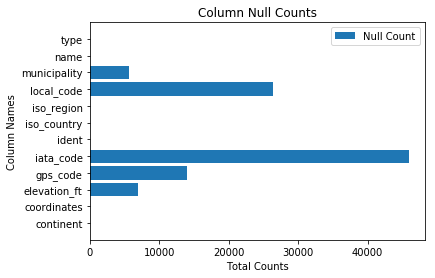

In [6]:
check_null_values(df_airport_codes_raw)

In [7]:
print("Number of duplicates in df_airport_codes_raw = {}".format(check_for_duplicates(df_airport_codes_raw)))

Number of duplicates in df_airport_codes_raw = 0


In [7]:
# Reading Demographics Data
df_demographics_raw = spark.read.option("header",True).option("delimiter",";").csv("us-cities-demographics.csv")
df_demographics_raw.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



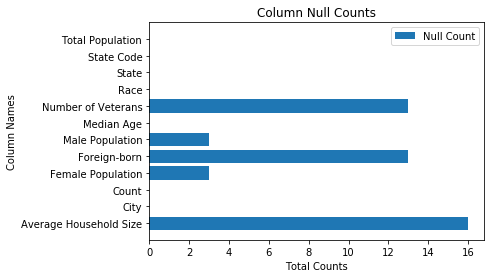

In [9]:
check_null_values(df_demographics_raw)

In [10]:
print("Number of duplicates in df_demographics_raw = {}".format(check_for_duplicates(df_demographics_raw)))

Number of duplicates in df_demographics_raw = 0


In [8]:
# Reading Immigration Data
df_immigration_raw = spark.read.parquet("sas_data/*").limit(5000)
df_immigration_raw.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

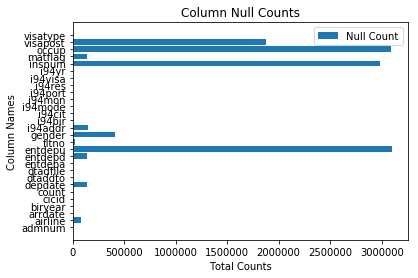

In [8]:
check_null_values(df_immigration_raw)

In [13]:
print("Number of duplicates in df_immigration_raw = {}".format(check_for_duplicates(df_immigration_raw)))

Number of duplicates in df_immigration_raw = 0


In [9]:
# Removing records with invalid city codes
df_immigration = df_immigration_raw.where("i94cit not in (403, 712, 700, 719, 574, 720, 106, 739, 394, 501, 404, 730, 731, 471, 737, 753, 740, 710, 505, 0, 705, 583, 407, 999, 239, 134, 506, 755, 311, 741, 54, 100, 187, 190, 200, 219, 238, 277, 293, 300, 319, 365, 395, 400, 485, 503, 589, 592, 791, 849, 914, 944, 996 )")

In [10]:
# Reading Temperature Data
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temperature_raw = spark.read.option("header",True).option("delimiter",",").csv(fname)
df_temperature_raw.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



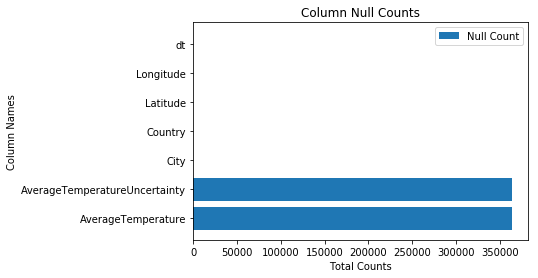

In [16]:
check_null_values(df_temperature_raw)

In [17]:
print("Number of duplicates in df_temperature_raw = {}".format(check_for_duplicates(df_temperature_raw)))

Number of duplicates in df_temperature_raw = 0


In [11]:
# Dropping records with null values in the Temperature fields
df_temperature = df_temperature_raw.na.drop(subset=["AverageTemperature", "AverageTemperatureUncertainty"])

In [12]:
# Reading State Codes
df_state_codes = spark.read.option("header", True).csv("state_codes.csv")
df_state_codes.createOrReplaceTempView("state_codes")
df_state_codes.printSchema()
df_state_codes.show(10, False)

root
 |-- state_code: string (nullable = true)
 |-- state_name: string (nullable = true)

+----------+-----------------+
|state_code|state_name       |
+----------+-----------------+
|AL        |ALABAMA          |
|AK        |ALASKA           |
|AZ        |ARIZONA          |
|AR        |ARKANSAS         |
|CA        |CALIFORNIA       |
|CO        |COLORADO         |
|CT        |CONNECTICUT      |
|DE        |DELAWARE         |
|DC        |DIST. OF COLUMBIA|
|FL        |FLORIDA          |
+----------+-----------------+
only showing top 10 rows



In [13]:
# Reading City Codes
df_country_codes = spark.read.option("header", True).csv("country_codes.csv")
df_country_codes.createOrReplaceTempView("country_codes")
df_country_codes.printSchema()
df_country_codes.show(10, False)

root
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)

+------------+---------------------------------------------------------+
|country_code|country_name                                             |
+------------+---------------------------------------------------------+
|582         |MEXICO Air Sea, and Not Reported (I-94, no land arrivals)|
|236         |AFGHANISTAN                                              |
|101         |ALBANIA                                                  |
|316         |ALGERIA                                                  |
|102         |ANDORRA                                                  |
|324         |ANGOLA                                                   |
|529         |ANGUILLA                                                 |
|518         |ANTIGUA-BARBUDA                                          |
|687         |ARGENTINA                                                |
|151         |ARMENIA         

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

This Data Model consists of a Star Schema with a Fact table and multiple dimension tables as mentioned below.

#### Dimension tables

#### dim_airport

airport_key (PK), airport_code, airport_type, airport_name, elevation_ft, continent, iso_country, iso_region, municipality, gps_code, iata_code, local_code, x_coordinate, y_coordinate

#### dim_demographics

demographics_key (PK), city_name, state_name, state_code, median_age, male_population, female_population, total_population, num_of_veterans, foreign_born, avg_household_size, race, count

#### dim_traveler

traveler_key (PK), age, gender, birth_year

#### dim_temperature

temperature_key (PK), date, avg_temp, avg_temp_uncertainty, city_name, country_code, country_name, latitude, longitude

#### Fact Table

#### fact_immigration

immigration_key (PK), airport_key (FK), demographics_key (FK), traveler_key (FK), temperature_key (FK), travel_mode, visa_type, travel_purpose, airline, flight_number, arrival_date, departure_date


#### 3.2 Mapping Out Data Pipelines

* Read input data from multiple sources.
* Clean the input data.
* Create and populate the airport dimension table.
* Create and populate the demographics dimension table.
* Create and populate the traveler dimension table.
* Create and populate the temperature dimension table.
* Create and populate the immigration fact table.
* Perform data quality checks on the data.



### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

Build the data pipelines to create the data model.


In [14]:
# Output paths for dimension and fact tables
dim_output_path = "dim_tables/"
fact_output_path = "fact_tables/"

In [15]:
def dim_airport(input_df, output_path):
    """
    This function takes the raw data for airport codes as input and creates a dimension table for airports.
    It returns the dataframe for the dimension table back to the calling function.
    
    :param input_df: Input Spark Dataframe for airport codes.
    :param output_path: Output Spark Dataframe for airport dimension table.
    """
    
    input_df.createOrReplaceTempView("airport_staging")
    
    sql_query = """
        
        WITH cte_airport 
        AS (
            SELECT  DISTINCT ident AS airport_code, 
                    type AS airport_type, 
                    name AS airport_name, 
                    CAST(elevation_ft AS BIGINT) AS elevation_ft, 
                    continent AS continent, 
                    iso_country AS iso_country,
                    split(iso_region, '-')[1] AS iso_region,
                    municipality AS municipality, 
                    gps_code AS gps_code,
                    iata_code AS iata_code,
                    local_code AS local_code,
                    CAST(split(coordinates,',')[0] AS DOUBLE) AS x_coordinate,
                    CAST(split(coordinates,',')[1] AS DOUBLE) AS y_coordinate
            FROM airport_staging
        )
        
        SELECT  monotonically_increasing_id() AS airport_key,
                airport_code, 
                airport_type, 
                airport_name, 
                elevation_ft, 
                continent, 
                iso_country,
                iso_region,
                municipality, 
                gps_code,
                iata_code,
                local_code,
                x_coordinate,
                y_coordinate
        FROM  cte_airport 
        LIMIT 5000
        
    """
    
    output_df = spark.sql(sql_query)
    
    output_df.write.mode("overwrite").parquet(output_path + "dim_airport")
    
    return output_df


In [16]:
df_dim_airport = dim_airport(df_airport_codes_raw, dim_output_path)

In [17]:
df_dim_airport.printSchema()

root
 |-- airport_key: long (nullable = false)
 |-- airport_code: string (nullable = true)
 |-- airport_type: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- elevation_ft: long (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)



In [18]:
df_dim_airport.show(10,False)

+-----------+------------+-------------+---------------------------------+------------+---------+-----------+----------+------------+--------+---------+----------+-------------------+------------------+
|airport_key|airport_code|airport_type |airport_name                     |elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|x_coordinate       |y_coordinate      |
+-----------+------------+-------------+---------------------------------+------------+---------+-----------+----------+------------+--------+---------+----------+-------------------+------------------+
|0          |03OR        |small_airport|Powwatka Ridge Airport           |3340        |NA       |US         |OR        |Troy        |03OR    |null     |03OR      |-117.48400115966797|45.85540008544922 |
|1          |08FD        |small_airport|Sunniland Ranch Airport          |65          |NA       |US         |FL        |Okeechobee  |08FD    |null     |08FD      |-80.77279663085938 |27.36

In [19]:
df_dim_airport.createOrReplaceTempView("dim_airport")

In [20]:
df_dim_airport.count()

5000

In [21]:
def dim_demographics(input_df, output_path):
    """
    This function takes the raw data for demographics as input and creates a dimension table for demographics.
    It returns the dataframe for the dimension table back to the calling function.
    
    :param input_df: Input Spark Dataframe for demographics.
    :param output_path: Output Spark Dataframe for demographics dimension table.
    """
    
    input_df.createOrReplaceTempView("demographics_staging")
    
    sql_query = """
    
        WITH cte_demographics 
        AS (
            SELECT  DISTINCT city AS city_name, 
                    state AS state_name, 
                    `state code` AS state_code,
                    CAST(`median age` AS DOUBLE) AS median_age, 
                    CAST(`male population` AS BIGINT) AS male_population, 
                    CAST(`female population` AS BIGINT) AS female_population, 
                    CAST(`total population` AS BIGINT) AS total_population, 
                    CAST(`number of veterans` AS BIGINT) AS num_of_veterans, 
                    CAST(`foreign-born` AS BIGINT) AS foreign_born, 
                    CAST(`average household size` AS FLOAT) AS avg_household_size, 
                    race, 
                    CAST(count AS BIGINT) AS count
            FROM demographics_staging
        )
        
        SELECT  monotonically_increasing_id() AS demographics_key,
                city_name, 
                state_name, 
                state_code,
                median_age, 
                male_population, 
                female_population, 
                total_population, 
                num_of_veterans, 
                foreign_born, 
                avg_household_size, 
                race, 
                count
        FROM cte_demographics
        LIMIT 5000
           
    """
    
    output_df = spark.sql(sql_query)
    
    output_df.write.mode("overwrite").parquet(output_path + "dim_demographics")

    return output_df


In [22]:
df_dim_demographics = dim_demographics(df_demographics_raw, dim_output_path)

In [23]:
df_dim_demographics.createOrReplaceTempView("dim_demographics")

In [24]:
df_dim_demographics.printSchema()

root
 |-- demographics_key: long (nullable = false)
 |-- city_name: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: long (nullable = true)
 |-- female_population: long (nullable = true)
 |-- total_population: long (nullable = true)
 |-- num_of_veterans: long (nullable = true)
 |-- foreign_born: long (nullable = true)
 |-- avg_household_size: float (nullable = true)
 |-- race: string (nullable = true)
 |-- count: long (nullable = true)



In [25]:
df_dim_demographics.show(10, False)

+----------------+----------+----------+----------+----------+---------------+-----------------+----------------+---------------+------------+------------------+---------------------------------+------+
|demographics_key|city_name |state_name|state_code|median_age|male_population|female_population|total_population|num_of_veterans|foreign_born|avg_household_size|race                             |count |
+----------------+----------+----------+----------+----------+---------------+-----------------+----------------+---------------+------------+------------------+---------------------------------+------+
|0               |South Bend|Indiana   |IN        |32.4      |50483          |53274            |103757          |3708           |8779        |2.72              |Asian                            |1788  |
|1               |Redding   |California|CA        |38.8      |42530          |49049            |91579           |6926           |5181        |2.42              |Asian                      

In [26]:
def dim_traveler(input_df, output_path):
    """
    This function takes the raw data for immigration as input and creates a dimension table for traveler data.
    It returns the dataframe for the dimension table back to the calling function.
    
    :param input_df: Input Spark Dataframe for immigration.
    :param output_path: Output Spark Dataframe for traveler dimension table.
    """
    
    input_df.createOrReplaceTempView("immigration_staging")

    sql_query = """
    
        WITH traveler_cte AS
        (
            SELECT  DISTINCT COALESCE(CAST(I94bir AS INTEGER), 0) AS age,
                    COALESCE(gender, 'N/A') AS gender,
                    COALESCE(CAST(biryear AS INTEGER), 0) AS birth_year
            FROM immigration_staging
        )
        SELECT  CONCAT(age, gender, birth_year) AS traveler_key,
                age,
                gender,
                birth_year
        FROM traveler_cte
        LIMIT 5000
        
    """

    output_df = spark.sql(sql_query)

    output_df.write.mode("overwrite").parquet(output_path + "dim_traveler")

    return output_df


In [27]:
df_dim_traveler = dim_traveler(df_immigration, dim_output_path)

In [28]:
df_dim_traveler.createOrReplaceTempView("dim_traveler")

In [29]:
df_dim_traveler.printSchema()

root
 |-- traveler_key: string (nullable = false)
 |-- age: integer (nullable = false)
 |-- gender: string (nullable = false)
 |-- birth_year: integer (nullable = false)



In [30]:
df_dim_traveler.show(10, False)

+------------+---+------+----------+
|traveler_key|age|gender|birth_year|
+------------+---+------+----------+
|53F1963     |53 |F     |1963      |
|60F1956     |60 |F     |1956      |
|46M1970     |46 |M     |1970      |
|58F1958     |58 |F     |1958      |
|73M1943     |73 |M     |1943      |
|62F1954     |62 |F     |1954      |
|17F1999     |17 |F     |1999      |
|28F1988     |28 |F     |1988      |
|31M1985     |31 |M     |1985      |
|47N/A1969   |47 |N/A   |1969      |
+------------+---+------+----------+
only showing top 10 rows



In [31]:
def dim_temperature(input_df, output_path):
    """
    This function takes the raw data for temperature as input and creates a dimension table for temperature data.
    It returns the dataframe for the dimension table back to the calling function.
    
    :param input_df: Input Spark Dataframe for temperature.
    :param output_path: Output Spark Dataframe for temperature dimension table.
    """
    
    
    input_df.createOrReplaceTempView("dim_temperature")

    sql_query = """
    
        WITH temperature_cte AS
        (
            SELECT  DISTINCT CAST(dt AS DATE) AS date,
                    CAST(AverageTemperature AS DOUBLE) AS avg_temp,
                    CAST(AverageTemperatureUncertainty AS DOUBLE) AS avg_temp_uncertainty,
                    CAST(City AS STRING) AS city_name,
                    CAST(cc.country_code AS INTEGER) AS country_code, 
                    CAST(Country AS STRING) AS country_name,
                    CAST(Latitude AS DOUBLE) AS latitude,
                    CAST(Longitude AS DOUBLE) AS longitude 
            FROM dim_temperature dtemp
            LEFT JOIN country_codes cc ON UPPER(dtemp.Country) = UPPER(cc.country_name) 
        )
        SELECT  monotonically_increasing_id() AS temperature_key,
                date,
                avg_temp,
                avg_temp_uncertainty,
                city_name,
                country_code,
                country_name,
                latitude,
                longitude 
        FROM temperature_cte
        LIMIT 5000
        
    """

    output_df = spark.sql(sql_query)

    output_df.write.mode("overwrite").parquet(output_path + "dim_temperature")

    return output_df


In [32]:
df_dim_temperature = dim_temperature(df_temperature, dim_output_path)

In [33]:
df_dim_temperature.createOrReplaceTempView("dim_temperature")

In [34]:
df_dim_temperature.printSchema()

root
 |-- temperature_key: long (nullable = false)
 |-- date: date (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- avg_temp_uncertainty: double (nullable = true)
 |-- city_name: string (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- country_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [35]:
df_dim_temperature.show(20, False)

+---------------+----------+------------------+--------------------+---------+------------+------------+--------+---------+
|temperature_key|date      |avg_temp          |avg_temp_uncertainty|city_name|country_code|country_name|latitude|longitude|
+---------------+----------+------------------+--------------------+---------+------------+------------+--------+---------+
|0              |1750-01-01|1.699             |1.013               |Århus    |108         |Denmark     |null    |null     |
|1              |1758-05-01|12.793            |6.694               |Århus    |108         |Denmark     |null    |null     |
|2              |1800-01-01|-3.167            |2.315               |Århus    |108         |Denmark     |null    |null     |
|3              |1818-08-01|15.098999999999998|1.29                |Århus    |108         |Denmark     |null    |null     |
|4              |1847-05-01|11.06             |1.088               |Århus    |108         |Denmark     |null    |null     |
|5      

In [43]:
def fact_immigration(input_df, output_path):
    """
    This function takes the raw data for immigration as input and creates a fact table containing United States immigration data.
    It returns the dataframe for the fact table back to the calling function.
    
    :param input_df: Input Spark Dataframe for immigration.
    :param output_path: Output Spark Dataframe for immigration fact table.
    """

    input_df.createOrReplaceTempView("immigration_staging")

    def convert_sas_timestamp(sas_timestamp):
        converted_timestamp = pd.to_timedelta(20566.0, unit='D') + pd.Timestamp('1960-1-1')
        return str(converted_timestamp)
    
    spark.udf.register("convert_sas_timestamp", convert_sas_timestamp)
    
    sql_query = """
    
        SELECT  monotonically_increasing_id() AS immigration_key,
                COALESCE(da.airport_key, -1) AS airport_key, 
                COALESCE(demo.demographics_key, -1) AS demographics_key,
                COALESCE(dt.traveler_key, -1) AS traveler_key,
                COALESCE(dtemp.temperature_key, -1) AS temperature_key,
                is.i94mode AS travel_mode, 
                is.visatype AS visa_type, 
                is.occup AS travel_purpose, 
                is.airline AS airline, 
                is.fltno AS flight_number,
                date(convert_sas_timestamp(is.arrdate)) AS arrival_date,
                date(convert_sas_timestamp(is.depdate)) AS departure_date
        FROM immigration_staging is
        LEFT JOIN dim_airport da ON is.i94port = da.airport_code
        LEFT JOIN dim_demographics demo ON is.I94addr = demo.state_code
        LEFT JOIN dim_traveler dt
            ON COALESCE(CAST(is.I94bir AS INTEGER), 0) = dt.age
              AND COALESCE(is.gender, 'N/A') = dt.gender
              AND COALESCE(CAST(is.biryear AS INTEGER), 0) = dt.birth_year
        LEFT JOIN dim_temperature dtemp 
            ON is.i94cit = dtemp.country_code
                AND ( date(convert_sas_timestamp(is.arrdate)) = dtemp.date
                      OR 
                      date(convert_sas_timestamp(is.depdate)) = dtemp.date
                      )
            
    """
    
    output_df = spark.sql(sql_query)
    
    output_df.write.mode("overwrite").parquet(output_path + "fact_immigration")
    
    return output_df


In [44]:
df_fact_immigration = fact_immigration(df_immigration, fact_output_path)

In [45]:
df_fact_immigration.createOrReplaceTempView("fact_immigration")

In [46]:
df_fact_immigration.printSchema()

root
 |-- immigration_key: long (nullable = false)
 |-- airport_key: long (nullable = false)
 |-- demographics_key: long (nullable = false)
 |-- traveler_key: string (nullable = false)
 |-- temperature_key: long (nullable = false)
 |-- travel_mode: double (nullable = true)
 |-- visa_type: string (nullable = true)
 |-- travel_purpose: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight_number: string (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- departure_date: date (nullable = true)



In [47]:
df_fact_immigration.show(10, False)

+---------------+-----------+----------------+------------+---------------+-----------+---------+--------------+-------+-------------+------------+--------------+
|immigration_key|airport_key|demographics_key|traveler_key|temperature_key|travel_mode|visa_type|travel_purpose|airline|flight_number|arrival_date|departure_date|
+---------------+-----------+----------------+------------+---------------+-----------+---------+--------------+-------+-------------+------------+--------------+
|0              |-1         |1649267441676   |53F1963     |-1             |1.0        |WT       |null          |LH     |00402        |2016-04-22  |2016-04-22    |
|1              |-1         |1649267441671   |53F1963     |-1             |1.0        |WT       |null          |LH     |00402        |2016-04-22  |2016-04-22    |
|2              |-1         |1623497637899   |53F1963     |-1             |1.0        |WT       |null          |LH     |00402        |2016-04-22  |2016-04-22    |
|3              |-1   

#### 4.2 Data Quality Checks

* Check the total counts in each dimension and fact tables are greater than zero to ensure data has been loaded properly.
* Check for duplicates in each table.

In [57]:
# Perform quality checks for data completeness and data accuracy.

def data_quality_checks(input_df, table_name):
    """
    This function takes the input dataframe and the table name and checks for the count of records in each table 
    to validate data completeness and checks if duplicates exist in the table for data quality.
    
    :param input_df: Input Spark Dataframe the table.
    :param table_name: Name of the table to be validated.
    """
    
    print("------------------------------------------------------")
    print("Tests for table {}".format(table_name))
    print("------------------------------------------------------")
    record_count = input_df.count()
    record_count_dedup = input_df.dropDuplicates().count()
    
    print("Check for Data Completeness")
    if record_count > 0:
        print("Test: Passed ( Count of records in table {} = {} )".format(table_name, record_count))
    else:
        print("Test: Failed ( Count of records in table {} = {} )".format(table_name, record_count))
        
    print("Check for Duplicate Records")
    if record_count == record_count_dedup:
        print("Test: Passed ( No duplicates found in table {} )".format(table_name))
    else:
        print("Test: Failed ( {} Duplicates found in table {} )".format(abs(record_count - record_count_dedup), table_name))


In [58]:
data_quality_checks(df_dim_airport, "dim_airport")

------------------------------------------------------
Tests for table dim_airport
------------------------------------------------------
Check for Data Completeness
Test: Passed ( Count of records in table dim_airport = 5000 )
Check for Duplicate Records
Test: Passed ( No duplicates found in table dim_airport )


In [59]:
data_quality_checks(df_dim_demographics, "dim_demographics")

------------------------------------------------------
Tests for table dim_demographics
------------------------------------------------------
Check for Data Completeness
Test: Passed ( Count of records in table dim_demographics = 2891 )
Check for Duplicate Records
Test: Passed ( No duplicates found in table dim_demographics )


In [60]:
data_quality_checks(df_dim_traveler, "dim_traveler")

------------------------------------------------------
Tests for table dim_traveler
------------------------------------------------------
Check for Data Completeness
Test: Passed ( Count of records in table dim_traveler = 250 )
Check for Duplicate Records
Test: Passed ( No duplicates found in table dim_traveler )


In [61]:
data_quality_checks(df_dim_temperature, "dim_temperature")

------------------------------------------------------
Tests for table dim_temperature
------------------------------------------------------
Check for Data Completeness
Test: Passed ( Count of records in table dim_temperature = 5000 )
Check for Duplicate Records
Test: Passed ( No duplicates found in table dim_temperature )


In [ ]:
data_quality_checks(df_fact_immigration, "fact_immigration")

------------------------------------------------------
Tests for table fact_immigration
------------------------------------------------------


#### 4.3 Data dictionary 

    dim_airport

    ----------------------------------------------------------------------------------------
    | Column Name  | Data Type | Description                                               |
    |--------------|-----------|-----------------------------------------------------------|
    | airport_key  | long      | Primary Key for dimension table                           |
    | airport_code | string    | Code assigned to each airport                             |
    | airport_type | string    | Type of the airport                                       |
    | airport_name | string    | Name of the airport                                       |
    | elevation_ft | long      | Elevation in feet of the airport above sea level          |
    | continent    | string    | Continent in which the airport is located                 |
    | iso_country  | string    | Country in which the airport is located                   |
    | iso_region   | string    | State in which the airport is located                     |
    | municipality | string    | Name of the Municipality managing the airport             |
    | gps_code     | string    | Code used to identify airport via GPS                     |
    | iata_code    | string    | International Air Transportation Association Airport Code |
    | local_code   | string    | Local airport code identifier                             |
    | x_coordinate | double    | x coordinate of the exact airport location                |
    | y_coordinate | double    | y coordinate of the exact airport location                |
    ----------------------------------------------------------------------------------------

    dim_demographics 
    
    -------------------------------------------------------------------------------------------
    | Column Name        | Data Type | Description                                            |
    |--------------------|-----------|--------------------------------------------------------|
    | demographics_key   | long      | Primary Key for dimension table                        |
    | city_name          | string    | Name of the city                                       |
    | state_name         | string    | Name of the state                                      |
    | state_code         | string    | Code for each state                                    |
    | median_age         | double    | Median age in the city                                 |
    | male_population    | long      | Total male population in the city                      |
    | female_population  | long      | Total female population in the city                    |
    | total_population   | long      | Total population in the city                           |
    | num_of_veterans    | long      | Total number of veterans in the city                   |
    | foreign_born       | long      | Total number of people born outside the city           |
    | avg_household_size | float     | Average number of people in each household in the city |
    | race               | string    | Race of the people in the city                         |
    | count              | long      | Count of people from a particular race in the city     |
    -------------------------------------------------------------------------------------------

    dim_traveler

    --------------------------------------------------------------
    | Column Name  | Data Type | Description                     |
    |--------------|-----------|---------------------------------|
    | traveler_key | string    | Primary Key for dimension table |
    | age          | integer   | Age of the traveler             |
    | gender       | string    | Gender of the traveler          |
    | birth_year   | integer   | Year of birth of traveler       |
    --------------------------------------------------------------
    
    dim_temperature
    
    ----------------------------------------------------------------------------------------
    | Column Name          | Data Type | Description                                       |
    |----------------------|-----------|---------------------------------------------------|
    | temperature_key      | string    | Primary Key for dimension table                   |
    | date                 | date      | Date on which temperature was recorded            |
    | avg_temp             | double    | Average temperature                               |
    | avg_temp_uncertainty | double    | Average uncertainty in temperature                |
    | city_name            | string    | Name of the city in which temperature is recorded |
    | country_code         | integer   | Code of the country                               |
    | country_name         | string    | Name of the country                               |
    | latitude             | double    | X Coordinate where temperature was measured       |
    | longitude            | double    | Y Coordinate where temperature was measured       |
    ----------------------------------------------------------------------------------------

    fact_immigration
    
    ---------------------------------------------------------------------------
    | Column Name      | Data Type | Description                              |
    |------------------|-----------|------------------------------------------|
    | immigration_key  | long      | Primary Key for dimension table          |
    | airport_key      | long      | Foreign Key to dim_airport               |
    | demographics_key | long      | Foreign Key to dim_demographics          |
    | traveler_key     | string    | Foreign Key to dim_traveler              |
    | temperature_key  | long      | Foreign Key to dim_temperature           |
    | travel_mode      | double    | Mode of travel                           |
    | visa_type        | string    | Type of Visa                             |
    | travel_purpose   | string    | Purpose of travel                        |
    | airline          | string    | Name of the airline                      |
    | flight_number    | string    | Flight Number                            |
    | arrival_date     | date      | Date of arrival into the United States   |
    | departure_date   | date      | Date of departure from the United States |
    ---------------------------------------------------------------------------
    

#### Step 5: Complete Project Write Up

##### Rationale for the choice of tools and technologies for the project.
Since the amount of data is going to be large and Apache Spark is being used for Data Processing at a fast speed. The cleaned and conformed data can be stored in S3. From there it can be made available to the users either via external tables in Redshift pointing to data in S3 or the data can be loaded to Redshift and made available as persistent tables in Redshift.

##### Propose how often the data should be updated and why

Since there is new immigration data that we get everyday, the data can be updated daily.

##### Write a description of how you would approach the problem differently under the following scenarios:

* The data was increased by 100x -  
    If the data increases we can increase the number of core nodes on the EMR or any cluster on which the Spark job is running. We can configure the cluster to auto scale if the load on the cluster increases or downsize automatically based on the usage of the cluster.

* The data populates a dashboard that must be updated on a daily basis by 7am every day - 
In order to support this we need a schedular to schedule and orchestrate the jobs. Apache Airflow can be used as a schedular to schedule jobs to populate the dimension tables and the fact tables daily at 7 AM.

* The database needed to be accessed by 100+ people - 
The data can be made available in a database like Redshift which is ideal for analytical queries on a Star Schema.